# Recommendation System Project: IBM Community
# By Fraser Fernandes


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)

df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

#### Treating Null Values

In [2]:
df.info()
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
nans = df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [3]:
print(f"Number of Null email values is: {nans}")

Number of Null email values is: article_id     0
title          0
email         17
dtype: int64


In [4]:
df['email'] = df['email'].fillna('unknown_user')
df['email'].isna().sum()

np.int64(0)

#### Descriptive statistics for the number of articles read per user (email)

In [5]:
user_article_counts = df.groupby('email')['article_id'].count()
user_article_counts.describe()

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

#### Distribution of User Engagement: Articles Read per User

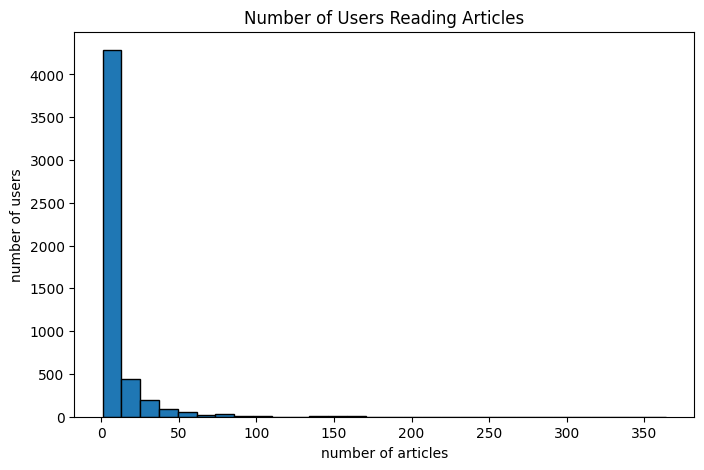

In [6]:
user_article_counts = df.groupby('email')['article_id'].count()

plt.figure(figsize=(8, 5))
plt.hist(user_article_counts, bins=30, edgecolor='k')

plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')

plt.show()

#### Distribution of Article Popularity: Users per Article

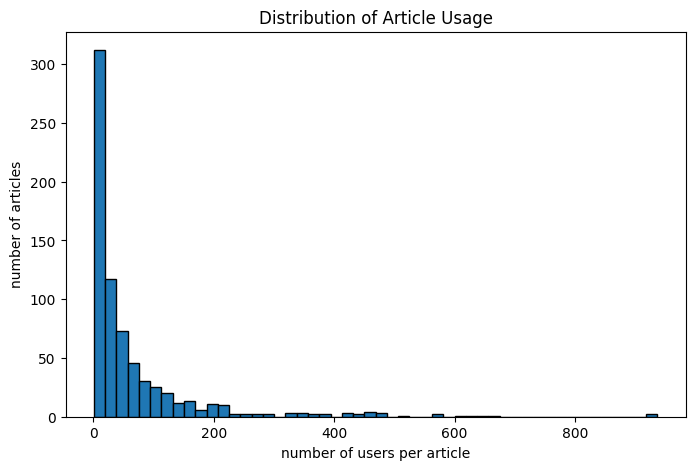

In [7]:
article_user_counts = df.groupby('article_id')['email'].count()

plt.figure(figsize=(8,5))
plt.hist(article_user_counts, bins = 50, edgecolor='k')

plt.xlabel('number of users per article')
plt.ylabel('number of articles')
plt.title('Distribution of Article Usage')
plt.show()

In [8]:
median_val =  user_article_counts.median()
max_views_by_user =  user_article_counts.max()

In [9]:
print(f"The Median number of articles read per user is {int(median_val)}")
print(f"The most number of articles ready by a user is {max_views_by_user}")

The Median number of articles read per user is 3
The most number of articles ready by a user is 364


In [10]:
unique_articles = df['article_id'].nunique()
total_articles =  df['article_id'].nunique()
unique_users =  df['email'].nunique()
user_article_interactions =  df['article_id'].count()

In [11]:
print(f"Users have interacted with {unique_articles}")
print(f"We have {unique_users} unique users are on our dataset")
print(f"Our dataset captures {user_article_interactions} unique interactions")

Users have interacted with 714
We have 5149 unique users are on our dataset
Our dataset captures 45993 unique interactions


In [12]:
most_viewed_article_id =  article_user_counts[article_user_counts == article_user_counts.max()].keys()[0]
max_views =  article_user_counts.max()

In [13]:
print(f"Article ID {most_viewed_article_id} is the most viewed article with {max_views} views")

Article ID 1429 is the most viewed article with 937 views


#### Creating a Mapping Function to assign User IDs

In [14]:
def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


### Test 1

In [15]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Rank-based recommendations suggest items based on their overall popularity or engagement metrics, such as the most-viewed or highest-rated content. This method does not consider individual user preferences but ensures widely liked items are recommended.

#### Functions to Retrieve the Most Popular Articles

In [16]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) dataset containing article interactions
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles  
    """
    
    # Count the number of users who interacted with each article
    article_user_counts = df.groupby('article_id')['user_id'].count()
    
    # Sort articles by interaction count in descending order
    top_ids = pd.DataFrame(article_user_counts.sort_values(ascending=False)).drop(['user_id'], axis=1)
    
    # Map article IDs to their corresponding titles
    title_map = df.groupby('article_id')['title'].first()
    
    # Join the sorted article IDs with their titles
    top_articles = top_ids.join(title_map)
    
    return top_articles['title'].tolist()[:n]


def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) dataset containing article interactions
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article IDs  
    """
    
    # Sort articles by interaction count and return the top 'n' article IDs
    top_articles = df.groupby('article_id')['user_id'].count().rename('views').sort_values(ascending=False).keys().tolist()[:n]
     
    return top_articles


In [17]:
print('Top 10 Articles:')
top_10_article = dict(zip(get_top_article_ids(10), get_top_articles(10)))
for i in top_10_article.keys():
    print(f'{i} - {top_10_article[i]}')

Top 10 Articles:
1429 - use deep learning for image classification
1330 - insights from new york car accident reports
1431 - visualize car data with brunel
1427 - use xgboost, scikit-learn & ibm watson machine learning apis
1364 - predicting churn with the spss random tree algorithm
1314 - healthcare python streaming application demo
1293 - finding optimal locations of new store using decision optimization
1170 - apache spark lab, part 1: basic concepts
1162 - analyze energy consumption in buildings
1304 - gosales transactions for logistic regression model


### Test 2

In [18]:
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

Collaborative filtering is a recommendation technique that suggests items based on user interactions and preferences. It identifies patterns by finding users with similar behaviors and recommending items they liked.

In [19]:
df

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5
...,...,...,...
45988,1324,ibm watson facebook posts for 2015,5146
45989,142,neural networks for beginners: popular types a...,5146
45990,233,bayesian nonparametric models – stats and bots,5147
45991,1160,analyze accident reports on amazon emr spark,5148


#### User-article matrix with 1's and 0's

In [20]:
def create_user_item_matrix(df, fill_value=0):
    """
    Creates a user-item interaction matrix.
    
    INPUT:
    df - pandas dataframe with article_id, title, and user_id columns
    
    OUTPUT:
    user_item - a matrix with users as rows and articles as columns, 
                with 1 indicating interaction and 0 otherwise
    """
    
    # Create a user-item matrix with interactions
    user_item = pd.crosstab(df['user_id'], df['article_id'])
    
    # Convert interaction values to binary (1 if interacted, else 0)
    user_item = user_item.map(lambda x: 1 if x > 0 else 0)
    
    return user_item

user_item = create_user_item_matrix(df)


In [21]:
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


#### Finding Similar Users Using Cosine Similarity

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    Finds similar users based on cosine similarity.
    
    INPUT:
    user_id - (int) target user ID
    user_item - (pandas DataFrame) user-article interaction matrix
    include_similarity - (bool) whether to return similarity scores
    
    OUTPUT:
    similar_users - (list) ordered list of similar users 
                    (with similarity scores if include_similarity is True)
    """
    
    # Get the target user's interaction vector
    target_vector = user_item.loc[user_id].values.reshape(1, -1)
    
    # Compute cosine similarity between all users and the target user
    cos_sim = cosine_similarity(user_item, target_vector).flatten()
    
    # Create a series of similarity scores indexed by user ID
    sim_series = pd.Series(cos_sim, index=user_item.index)
    
    # Remove the target user from the list and sort users by similarity
    sim_series = sim_series.drop(user_id)
    sim_series = sim_series.sort_values(ascending=False)
    
    similar_users = [[uid, sim] for uid, sim in sim_series.items()] if include_similarity else sim_series.index.tolist()
    
    return similar_users


In [24]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 4201, 46, 824, 5034, 253, 5041, 136, 2305, 395]
The 5 most similar users to user 3933 are: [1, 46, 4201, 824, 5034]
The 3 most similar users to user 46 are: [4201, 790, 5077]


#### Functions for Retrieving and Recommending Articles to Users

In [25]:
def get_article_names(article_ids, df=df):
    """
    Retrieves article names corresponding to given article IDs.
    """
    # Filter the dataset for the given article IDs and extract titles
    article_names = df[df['article_id'].isin(article_ids)].groupby('article_id').first()['title'].values.tolist()
    
    return article_names


def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    Returns a sorted list of article IDs and their unique user interaction counts.
    """
    counts = {}

    # Count the number of unique users who have interacted with each article
    for article in article_ids:
        if article in user_item.columns:
            counts[article] = user_item[article].sum()
        else:
            counts[article] = 0

    # Sort articles by interaction count in descending order
    ranked = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    ranked_article_counts = [list(item) for item in ranked]

    return ranked_article_counts


def get_user_articles(user_id, user_item=user_item):
    """
    Retrieves the list of article IDs and corresponding article names that a user has interacted with.
    """
    # Get the list of articles the user has interacted with
    article_ids = user_item.columns[user_item.loc[user_id] == 1].tolist()
    article_names = get_article_names(article_ids, df=df)
    
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    """
    Generates article recommendations for a user based on similar users.
    """
    user_seen = set(user_item.columns[user_item.loc[user_id] == 1])
    similar_users = find_similar_users(user_id)  # Get users most similar to the input user
    
    recs = []

    # Iterate over similar users to find articles they have read but the input user hasn't
    for other_user in similar_users:
        other_seen = set(user_item.columns[user_item.loc[other_user] == 1])
        new_articles = list(other_seen - user_seen)  # Get articles not seen by the input user

        for article in new_articles:
            if article not in recs:
                recs.append(article)

            if len(recs) >= m:  # Stop once we have enough recommendations
                break

        if len(recs) >= m:
            break

    return recs


In [26]:
get_article_names(user_user_recs(1, 10))

['this week in data science (april 18, 2017)',
 'improving the roi of big data and analytics through leveraging new sources of data',
 'awesome deep learning papers',
 '15 page tutorial for r',
 'workflow in r',
 'access mysql with r',
 'analyze energy consumption in buildings',
 'analyze open data sets with pandas dataframes',
 'country statistics: airports',
 'use sql with data in hadoop python']

In [27]:
get_ranked_article_unique_counts([1320, 232, 844])[0]

[1320, np.int64(123)]

In [28]:
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


#### Prioritizing Similar Users and High-Interaction Articles for Better Recommendations

In [29]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    Finds similar users based on interaction patterns, ranks them by similarity,
    and sorts by interaction count in descending order.
    
    INPUT:
    user_id - (int) a user ID
    user_item - (pandas dataframe) user-article interaction matrix (1 if interacted, 0 otherwise)
    
    OUTPUT:
    neighbors_df - (pandas dataframe) containing:
                    neighbor_id - ID of the neighboring user
                    similarity - similarity score with the input user
                    num_interactions - total articles viewed by the user
    """
    # Compute cosine similarity between the target user and all users
    target_vector = user_item.loc[user_id].values.reshape(1, -1)
    all_vectors = user_item.values
    similarity_scores = cosine_similarity(all_vectors, target_vector).flatten()

    # Convert similarity scores into a Series and remove the input user
    sim_series = pd.Series(similarity_scores, index=user_item.index)
    sim_series.drop(user_id, inplace=True)

    # Get total interactions for each user
    interaction_counts = user_item.sum(axis=1)

    # Create a dataframe of neighboring users sorted by similarity and interactions
    neighbors_df = pd.DataFrame({
        'neighbor_id': sim_series.index,
        'similarity': sim_series.values,
        'num_interactions': interaction_counts.loc[sim_series.index].values
    })

    neighbors_df.sort_values(by=['similarity', 'num_interactions'], 
                             ascending=False, inplace=True)
    
    neighbors_df.reset_index(drop=True, inplace=True)
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10, user_item=user_item, df=df):
    """
    Recommends articles to a user by finding similar users, prioritizing users with the highest
    similarity and interaction count. The function selects unseen articles from these users
    while prioritizing popular articles.

    INPUT:
    user_id - (int) a user ID
    m - (int) number of recommendations to return
    user_item - (pandas dataframe) user-article interaction matrix
    df - (pandas dataframe) dataset containing article details
    
    OUTPUT:
    recs - (list) recommended article IDs
    rec_names - (list) recommended article titles
    """
    neighbors_df = get_top_sorted_users(user_id, user_item)  # Get sorted list of similar users
    user_seen = set(user_item.columns[user_item.loc[user_id] == 1])  # Articles already seen by the user
    
    recs = []
    
    # Get the interaction count for each article to prioritize popular ones
    article_interactions = user_item.sum(axis=0)

    # Iterate through similar users and get new article recommendations
    for _, row in neighbors_df.iterrows():
        neighbor_id = row['neighbor_id']
        neighbor_seen = set(user_item.columns[user_item.loc[neighbor_id] == 1])

        # Sort neighbor's articles by popularity
        sorted_articles = sorted(neighbor_seen, 
                                 key=lambda x: article_interactions[x], 
                                 reverse=True)

        # Add unseen articles to recommendations
        for article_id in sorted_articles:
            if article_id not in user_seen and article_id not in recs:
                recs.append(article_id)
                if len(recs) >= m:
                    break
        
        if len(recs) >= m:
            break

    rec_names = get_article_names(recs, df=df)  # Retrieve article titles
    
    return recs, rec_names


In [30]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1185, 1162, 1165, 1293, 254, 1271, 1328, 1410, 40, 1402]

The top 10 recommendations for user 20 are the following article names:
['ensemble learning to improve machine learning results', 'apple, ibm add machine learning to partnership with watson-core ml coupling', 'analyze energy consumption in buildings', 'analyze precipitation data', 'classify tumors with machine learning', 'customer demographics and sales', 'finding optimal locations of new store using decision optimization', 'income (2015): united states demographic measures', 'uci: adult - predict income', 'uci: sms spam collection']


In [31]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
   neighbor_id  similarity  num_interactions
0         5083    0.730297                 5
1         1552    0.577350                 2
2         1890    0.577350                 2
3         1372    0.471405                 3
4         2941    0.433013                 8
5         3586    0.408248                 4
6          331    0.408248                 1
7          348    0.408248                 1
8          378    0.408248                 1
9          496    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1          203    0.388909                96
2         4459    0.388909                96
3         3782    0.387585               135
4           40    0.384308                52
5         4932    0.384308                52
6           23    0.377647               135
7          242    0.375823                59
8         

### Test 5

In [32]:
user1_most_sim =  get_top_sorted_users(1, user_item).iloc[0]['neighbor_id']      # Find the user that is most similar to user 1 
user2_6th_sim =  get_top_sorted_users(2, user_item).iloc[5]['neighbor_id']       # Find the 6th most similar user to user 2
user131_10th_sim =  get_top_sorted_users(131, user_item).iloc[9]['neighbor_id']  # Find the 10th most similar user to user 131

In [33]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


Since the user is new, we cannot use collaborative or content-based filtering due to a lack of interaction data. Instead, we will use a popularity-based recommendation system.

Another way we could recommend articles is by allowing new users to select topics they're interested in while signing up and then using a knowledge-based recommendation system.

In [34]:
new_user_recs = get_top_article_ids(10)
new_user_recs

[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]

In [35]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.

In [36]:
# Viewing Our Dataset
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [37]:
# Importing Necessary Libraries

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [38]:
# Creating a Dataset With Unique Articles

df_unique_articles = df.groupby('article_id')['title'].first()
df_unique_articles

article_id
0       detect malfunctioning iot sensors with streami...
2              this week in data science (april 18, 2017)
4           analyze ny restaurant data using spark in dsx
8                                  data science bowl 2017
9       3992    using apache spark to predict attack v...
                              ...                        
1440                                  world marriage data
1441    world tourism data by the world tourism organi...
1442    worldwide county and region - national account...
1443    worldwide electricity demand and production 19...
1444    worldwide fuel oil consumption by household (i...
Name: title, Length: 714, dtype: object

**Applying TF-IDF and Latent Semantic Analysis (LSA) to Article Titles**

In [39]:
# Set parameters for TF-IDF vectorization
max_features = 200
max_df = 0.75
min_df = 5

# Initialize the TF-IDF vectorizer to transform article titles into numerical features
vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)

print("Running TF-IDF")

# Fit the vectorizer to the unique article titles and transform them into a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(df_unique_articles)

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

# Apply Latent Semantic Analysis (LSA) using Truncated SVD followed by normalization
lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)

# Compute and display the explained variance
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")


Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


#### Determining the Optimal Number of Clusters Using K-Means

Text(0.5, 0, 'Number of clusters')

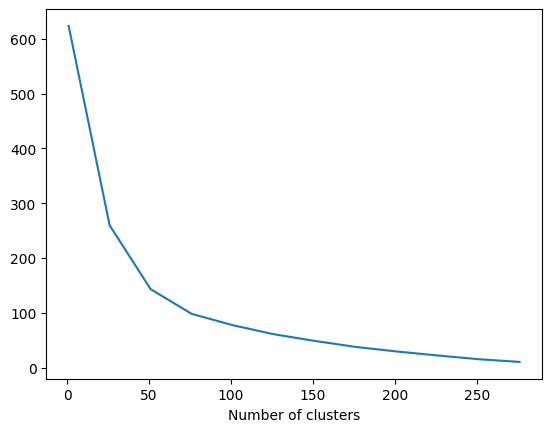

In [40]:
# Initialize parameters for k-means clustering
clusters = 300 
step = 25 
max_iter = 50 
n_init = 5 
random_state = 42 

inertia = []

# Compute inertia for different numbers of clusters
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    
    inertia.append(kmeans.inertia_)  # Sum of squared distances to nearest cluster center

# Plot the inertia values to determine the optimal number of clusters
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')


There appears to be an elbow about 50, so we'll use 50 clusters.

In [41]:
# Initilising and fitting k-means clustering

n_clusters = 50

kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
kmeans.fit(X_lsa)

labels = kmeans.labels_

In [42]:
# Assigning labels to clusters
article_cluster_map = dict(zip(df_unique_articles.index,labels))
df['title_cluster'] = df['article_id'].map(article_cluster_map)

In [43]:
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 10],
       [ 1,  9],
       [ 2, 28],
       [ 3, 30],
       [ 4, 76],
       [ 5, 37],
       [ 6,  9],
       [ 7, 13],
       [ 8, 21],
       [ 9, 15],
       [10, 36],
       [11, 12],
       [12, 20],
       [13, 23],
       [14,  8],
       [15, 23],
       [16, 19],
       [17, 19],
       [18,  1],
       [19, 11],
       [20,  4],
       [21, 21],
       [22, 18],
       [23,  5],
       [24, 10],
       [25,  8],
       [26, 17],
       [27,  7],
       [28, 20],
       [29,  9],
       [30,  7],
       [31,  9],
       [32, 11],
       [33,  9],
       [34,  8],
       [35,  7],
       [36,  5],
       [37, 13],
       [38,  6],
       [39,  8],
       [40,  7],
       [41, 10],
       [42,  9],
       [43,  8],
       [44, 16],
       [45, 10],
       [46,  5],
       [47, 10],
       [48, 10],
       [49,  7]])

#### Retrieving Similar Articles Based on Title Clusters

In [44]:
def get_similar_articles(article_id, df=df):
    """
    Finds articles that belong to the same title cluster as the given article.

    INPUT:
    article_id - (int) an article ID 
    df - (pandas dataframe) dataset containing article details and their title clusters
    
    OUTPUT:
    article_ids - (list) a list of article IDs in the same title cluster
    
    DESCRIPTION:
    Identifies and returns a list of article IDs that are grouped under the same title cluster,
    excluding the input article itself.
    """
    # Find the cluster label associated with the given article_id
    title_cluster = df.loc[df['article_id'] == article_id, 'title_cluster'].values

    if len(title_cluster) == 0:
        return []  # Return an empty list if the article_id is not found

    title_cluster = title_cluster[0]  # Extract the cluster label

    # Get all articles within the same cluster
    articles_in_cluster = df[df['title_cluster'] == title_cluster]['article_id'].tolist()

    # Remove the input article_id from the list to avoid self-recommendation
    articles_in_cluster = [art_id for art_id in articles_in_cluster if art_id != article_id]

    return articles_in_cluster


#### Content-Based Article Recommendations Using Title Clustering and Popularity Ranking

In [45]:
def make_content_recs(article_id, n, df=df, user_item=user_item):
    """
    Generates content-based article recommendations using title clustering and popularity ranking.

    INPUT:
    article_id - (int) an article ID
    n - (int) number of recommendations desired
    df - (pandas dataframe) dataset containing article details and title clusters
    user_item - (pandas dataframe) matrix of users by articles (1 if interacted, 0 otherwise)
    
    OUTPUT:
    n_ranked_similar_articles - (list) top N article IDs from the same title cluster, ranked by popularity
    n_ranked_article_names - (list) corresponding article titles
    
    DESCRIPTION:
    Finds articles in the same title cluster as the given article_id and ranks them by popularity 
    using the get_ranked_article_unique_counts function. Returns the top N recommended articles.
    """
    # Get similar articles from the same title cluster
    similar_articles = get_similar_articles(article_id, df)

    # If no similar articles are found, return empty lists
    if not similar_articles:
        return [], []

    # Rank similar articles by popularity (based on unique user interactions)
    ranked_articles = get_ranked_article_unique_counts(similar_articles, user_item)

    # Extract the top N ranked article IDs
    ranked_article_ids = [article[0] for article in ranked_articles][:n]

    # Retrieve article titles corresponding to the recommended article IDs
    n_ranked_article_names = df[df['article_id'].isin(ranked_article_ids)]['title'].tolist()[:n]

    return ranked_article_ids, n_ranked_article_names


In [46]:
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 101, 975, 766, 508, 547, 132, 878, 92, 693]
['better together: spss and data science experience', 'data science in the cloud', 'collecting data science cheat sheets', 'making data science a team sport', 'data science in the cloud', 'better together: spss and data science experience', 'better together: spss and data science experience', 'better together: spss and data science experience', 'how to choose a project to practice data science', 'data tidying in data science experience']


In [47]:
len(rec_article_titles)

10

In [48]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

**1. Text Processing:**

    - We convert article titles into numerical features using TF-IDF vectorization and apply Latent Semantic Analysis (LSA) for dimensionality reduction.

**2. Clustering with K-Means:**

    - Articles are grouped into 50 clusters based on content similarity.

**3. Generating Recommendations:**

    - Given an article, we find other articles in the same cluster.
    - These articles are ranked by popularity (unique user interactions).
    - The top N articles are returned as recommendations.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In [49]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Extracting Latent Features Using Truncated SVD

In [50]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Conducting SVD using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 

print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


#### Determining the Optimal Number of Latent Features

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

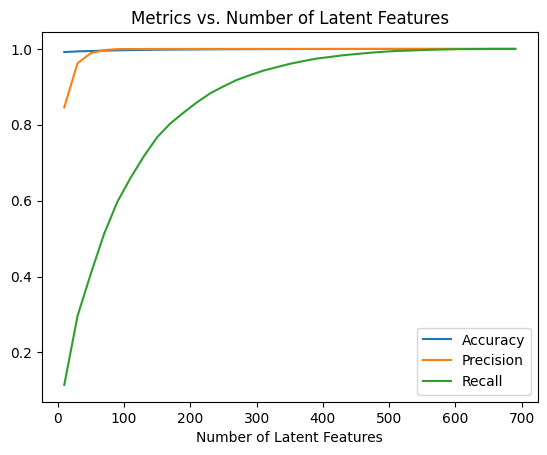

In [51]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])


plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

Based on the plot, an optimal number of latent features would be around 200. Accuracy and precision reach near-perfect levels early, while recall improves steadily with more features. However, beyond 200, recall shows diminishing returns, indicating that additional features add complexity without significantly enhancing performance. To optimize efficiency and prevent overfitting, we select 200 latent features as a balanced choice for our model.

#### Generating a List of Similar Article Id's

In [52]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_svd_similar_article_ids(article_id, vt, user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are similar based on SVD factorization
    
    Description:
    Returns a list of article ids similar to the given article_id using cosine similarity.
    """
    # Get the list of article ids
    article_ids = user_item.columns.tolist()
    
    # Find the index of the article_id in the user_item matrix
    if article_id not in article_ids:
        return []  # Return empty list if article_id is not in dataset
    
    article_idx = article_ids.index(article_id)

    # Compute the cosine similarity matrix (transpose vt to get articles as rows)
    cos_sim = cosine_similarity(vt.T)

    # Get similarity scores for the given article
    sim_scores = list(enumerate(cos_sim[article_idx]))

    # Sort articles based on similarity scores (excluding the input article)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the most similar article ids (excluding the given article_id)
    most_similar_items = [(article_ids[idx], score) for idx, score in sim_scores if article_ids[idx] != article_id]

    if include_similarity:
        return most_similar_items  # List of tuples (article_id, similarity_score)
    
    return [article[0] for article in most_similar_items]  # List of article IDs only


In [53]:
# Creating a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [54]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [55]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [56]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['advancements in the spark community',
 'collecting data science cheat sheets',
 'top analytics tools in 2016',
 'notebooks: a power tool for data scientists',
 'use spark r to load and analyze data',
 '10 powerful features on watson data platform, no coding necessary',
 'airbnb data for analytics: athens reviews',
 'airbnb data for analytics: paris calendar',
 'country statistics: crude oil - exports',
 'country statistics: crude oil - proved reserves']

In [57]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


## Our Approach

**New User With No History**  
- Due to a lack of history, content-based and collaborative filtering will not be possible. In this case, it would be best to use **popularity-based recommendations**, where the most popular articles are suggested. This is a safe approach as it simply lists some of the most popular articles on the platform.  
- Another alternative is **knowledge-based recommendations**, where at the time of signup we can collect the users intrest and priorotise it.

**New User With Little History**  
- For users with limited interaction history, we will not use popularity-based recommendations, as it would be too ambiguous. We will also avoid collaborative filtering as it requires a significant number of interactions to effectively identify similar users.  
- Instead, we can use a **content-based recommendation system**, which analyzes article titles using TF-IDF, forms clusters, and recommends articles from within the same cluster.

**Users With a Lot of History**  
- For users with a substantial interaction history, **collaborative filtering** is the most effective approach. By analyzing past interactions, we can identify users with similar interests and recommend articles based on their reading patterns.  
- A **hybrid approach** can further improve accuracy by integrating content-based filtering with collaborative filtering to ensure diverse and relevant recommendations.

In [58]:
from subprocess import call
call(['python', '-m', 'nbconvert', '--to', 'html', 'Recommendations_with_IBM.ipynb'])


[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 526438 bytes to Recommendations_with_IBM.html


0